# Phase 2: Electricity Price Forecasting for ERCOT Market

**Objective:** Build and compare multiple forecasting models for day-ahead electricity prices, with emphasis on volatility modeling using GARCH techniques.

**Author:** Amalie Berg  
**Contact:** berg.amalie@outlook.com | [LinkedIn](https://linkedin.com/in/amalie-berg)

---

## Business Context

Accurate electricity price forecasting is critical for:
- **Revenue optimization:** Deciding when to sell renewable generation
- **Risk management:** Understanding price volatility for hedging decisions
- **Portfolio valuation:** Pricing long-term renewable contracts
- **Trading strategies:** Identifying arbitrage opportunities

**Key Challenge:** Electricity prices exhibit:
- Strong seasonality (daily, weekly, annual)
- High volatility and price spikes
- Volatility clustering (GARCH effects)
- Non-linear relationships with weather and demand

---

## Contents
1. [Setup & Data Loading](#setup)
2. [Feature Engineering](#features)
3. [Statistical Models](#statistical)
   - ARIMA
   - GARCH (Volatility Modeling)
4. [Machine Learning Models](#ml)
   - XGBoost
   - Random Forest
5. [Deep Learning](#dl)
   - LSTM
6. [Model Comparison](#comparison)
7. [Key Insights](#insights)

## 1. Setup & Data Loading <a id='setup'></a>

In [5]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Deep Learning (optional - requires TensorFlow)
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("TensorFlow not available. LSTM model will be skipped.")
    print("Install with: pip install tensorflow")
    TENSORFLOW_AVAILABLE = False

# Plotting configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Random seed
np.random.seed(42)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [6]:
# Load data (generated from Phase 1)
df = pd.read_csv('../data/processed/merged_data.csv', parse_dates=['datetime'])
df.set_index('datetime', inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {list(df.columns)}")

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Data shape: (17521, 19)
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00

Columns: ['settlement_point', 'dam_price', 'system_load_mw', 'wind_generation_mw', 'solar_generation_mw', 'total_renewable_mw', 'temperature_f', 'solar_irradiance_w_m2', 'wind_speed_ms', 'hour', 'day_of_week', 'month', 'is_weekend', 'price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_ma_24h', 'price_std_24h', 'renewable_penetration']

Missing values: 239


## 2. Feature Engineering <a id='features'></a>

Create features that capture:
- Temporal patterns (hour, day, month, season)
- Lags and rolling statistics
- Calendar effects (weekday, weekend, holidays)
- Weather and generation variables

In [7]:
def create_features(df):
    """
    Create time series features for price forecasting.
    """
    df = df.copy()
    
    # Target variable
    df['price'] = df['dam_price']
    
    # ===== Temporal features =====
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week
    
    # Weekend indicator
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Season (meteorological)
    df['season'] = df['month'].map({
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'fall', 10: 'fall', 11: 'fall'
    })
    
    # ===== Lag features =====
    # Price lags (1h, 24h, 168h=1week)
    df['price_lag_1h'] = df['price'].shift(1)
    df['price_lag_24h'] = df['price'].shift(24)
    df['price_lag_168h'] = df['price'].shift(168)
    
    # Same hour yesterday and last week
    df['price_same_hour_yesterday'] = df['price'].shift(24)
    df['price_same_hour_last_week'] = df['price'].shift(168)
    
    # ===== Rolling statistics =====
    # 24-hour rolling window
    df['price_rolling_mean_24h'] = df['price'].rolling(window=24, min_periods=1).mean()
    df['price_rolling_std_24h'] = df['price'].rolling(window=24, min_periods=1).std()
    df['price_rolling_min_24h'] = df['price'].rolling(window=24, min_periods=1).min()
    df['price_rolling_max_24h'] = df['price'].rolling(window=24, min_periods=1).max()
    
    # 7-day rolling window
    df['price_rolling_mean_7d'] = df['price'].rolling(window=168, min_periods=1).mean()
    df['price_rolling_std_7d'] = df['price'].rolling(window=168, min_periods=1).std()
    
    # ===== Exogenous variables =====
    # Load-related
    df['load_lag_1h'] = df['system_load_mw'].shift(1)
    df['load_lag_24h'] = df['system_load_mw'].shift(24)
    
    # Renewable generation
    df['wind_lag_1h'] = df['wind_generation_mw'].shift(1)
    df['solar_lag_1h'] = df['solar_generation_mw'].shift(1)
    df['renewable_share'] = df['total_renewable_mw'] / df['system_load_mw']
    
    # Net load (demand minus renewables)
    df['net_load'] = df['system_load_mw'] - df['total_renewable_mw']
    df['net_load_lag_1h'] = df['net_load'].shift(1)
    
    # Weather
    df['temp_lag_1h'] = df['temperature_f'].shift(1)
    df['wind_speed_lag_1h'] = df['wind_speed_ms'].shift(1)
    
    # ===== Cyclical encoding (for ML models) =====
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

# Create features
df_features = create_features(df)

# Drop rows with NaN (from lagging)
df_features = df_features.dropna()

print(f"Feature engineering complete!")
print(f"New shape: {df_features.shape}")
print(f"\nFeature columns: {len(df_features.columns)}")

Feature engineering complete!
New shape: (17353, 48)

Feature columns: 48


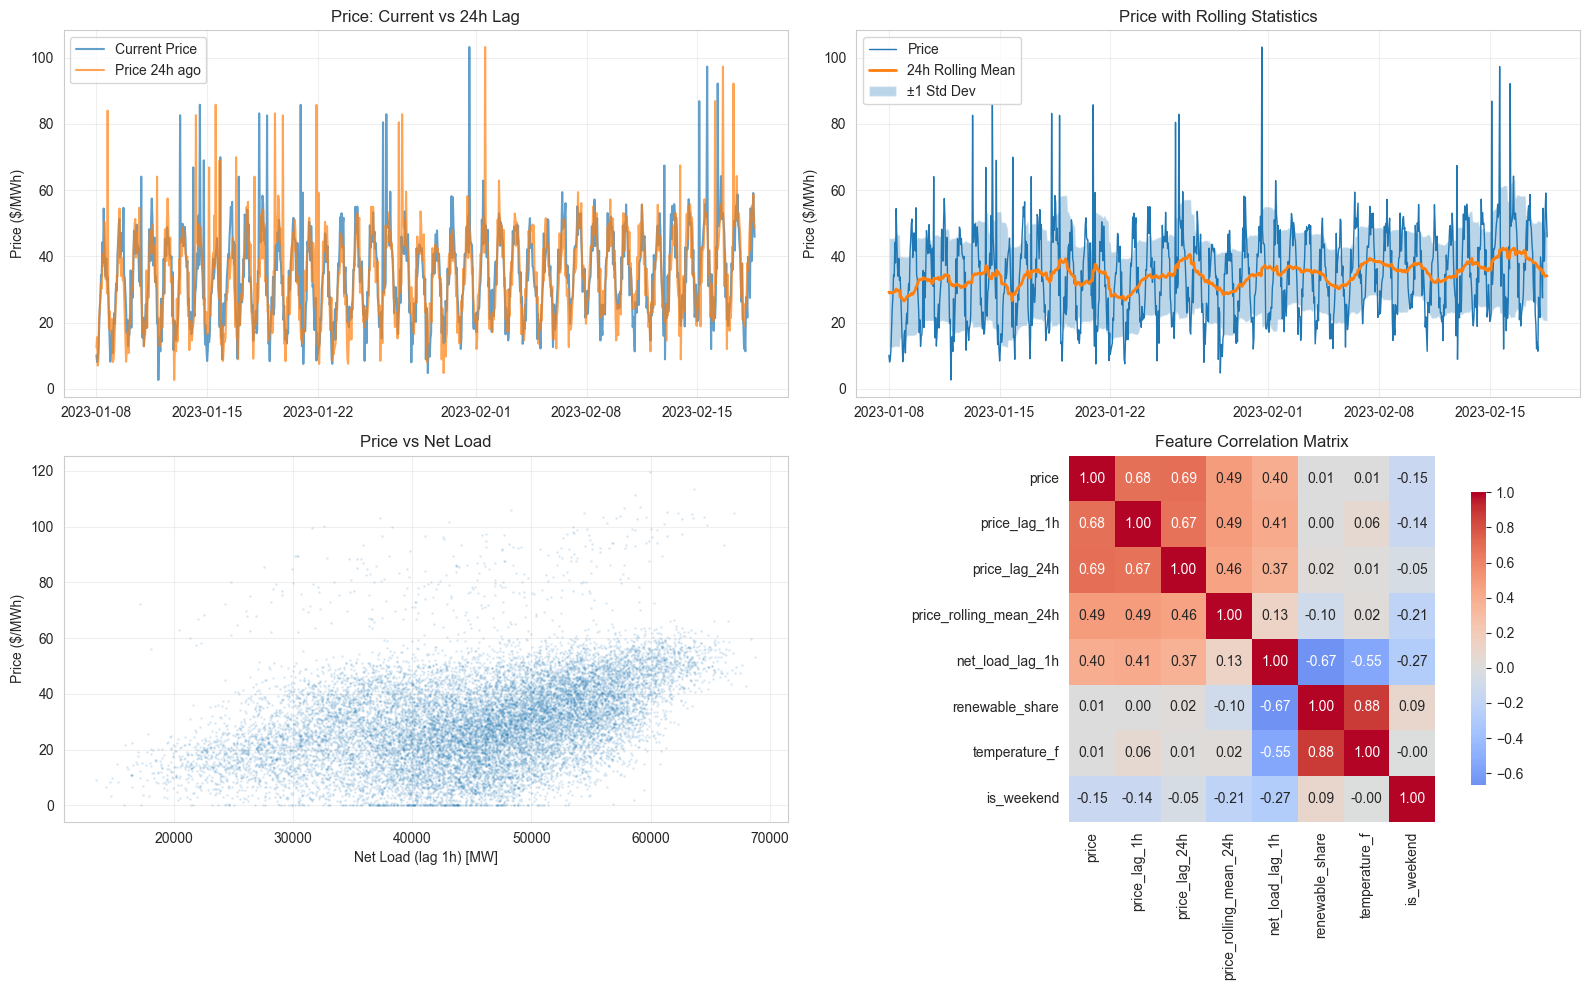

<Figure size 1400x600 with 0 Axes>

In [8]:
# Visualize some key features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price vs lag features
sample = df_features.iloc[:1000]  # First ~6 weeks
axes[0, 0].plot(sample.index, sample['price'], label='Current Price', alpha=0.7)
axes[0, 0].plot(sample.index, sample['price_lag_24h'], label='Price 24h ago', alpha=0.7)
axes[0, 0].set_ylabel('Price ($/MWh)')
axes[0, 0].set_title('Price: Current vs 24h Lag')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Rolling statistics
axes[0, 1].plot(sample.index, sample['price'], label='Price', linewidth=1)
axes[0, 1].plot(sample.index, sample['price_rolling_mean_24h'], label='24h Rolling Mean', linewidth=2)
axes[0, 1].fill_between(sample.index, 
                         sample['price_rolling_mean_24h'] - sample['price_rolling_std_24h'],
                         sample['price_rolling_mean_24h'] + sample['price_rolling_std_24h'],
                         alpha=0.3, label='±1 Std Dev')
axes[0, 1].set_ylabel('Price ($/MWh)')
axes[0, 1].set_title('Price with Rolling Statistics')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Correlation with net load
axes[1, 0].scatter(df_features['net_load_lag_1h'], df_features['price'], alpha=0.1, s=1)
axes[1, 0].set_xlabel('Net Load (lag 1h) [MW]')
axes[1, 0].set_ylabel('Price ($/MWh)')
axes[1, 0].set_title('Price vs Net Load')
axes[1, 0].grid(alpha=0.3)

# Feature correlation heatmap (top features)
feature_cols = ['price', 'price_lag_1h', 'price_lag_24h', 'price_rolling_mean_24h',
                'net_load_lag_1h', 'renewable_share', 'temperature_f', 'is_weekend']
corr_matrix = df_features[feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=axes[1, 1], cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Feature Correlation Matrix')

plt.tight_layout()

import os

# Ensure the directory exists
os.makedirs('../docs', exist_ok=True)

plt.tight_layout()
plt.savefig('../docs/04_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


plt.savefig('../docs/04_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Statistical Models <a id='statistical'></a>

### Train-Test Split

Use time-based split to avoid look-ahead bias:
- **Training:** First 80% of data
- **Testing:** Last 20% of data

In [9]:
# Split data
train_size = int(len(df_features) * 0.8)
train_df = df_features.iloc[:train_size]
test_df = df_features.iloc[train_size:]

print(f"Training set: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} hours)")
print(f"Test set: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} hours)")

# Extract target
y_train = train_df['price']
y_train = y_train.asfreq('H')  # Set frequency to hourly
y_test = test_df['price']

Training set: 2023-01-08 00:00:00 to 2024-08-08 09:00:00 (13882 hours)
Test set: 2024-08-08 10:00:00 to 2024-12-31 00:00:00 (3471 hours)


### 3.1 ARIMA Model

**AutoRegressive Integrated Moving Average**

Classic time series model that captures:
- **AR (p):** Autoregressive terms - price depends on its past values
- **I (d):** Integration order - differencing to achieve stationarity
- **MA (q):** Moving average - price depends on past forecast errors

In [10]:
# Check stationarity
def check_stationarity(series, name='Series'):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(series.dropna())
    print(f"\n{name} - ADF Test:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"  → Series is stationary (reject H0)")
        return True
    else:
        print(f"  → Series is non-stationary (fail to reject H0)")
        return False

is_stationary = check_stationarity(y_train, 'Price Series')


Price Series - ADF Test:
  ADF Statistic: -5.9342
  p-value: 0.0000
  Critical Values:
    1%: -3.4308
    5%: -2.8617
    10%: -2.5669
  → Series is stationary (reject H0)


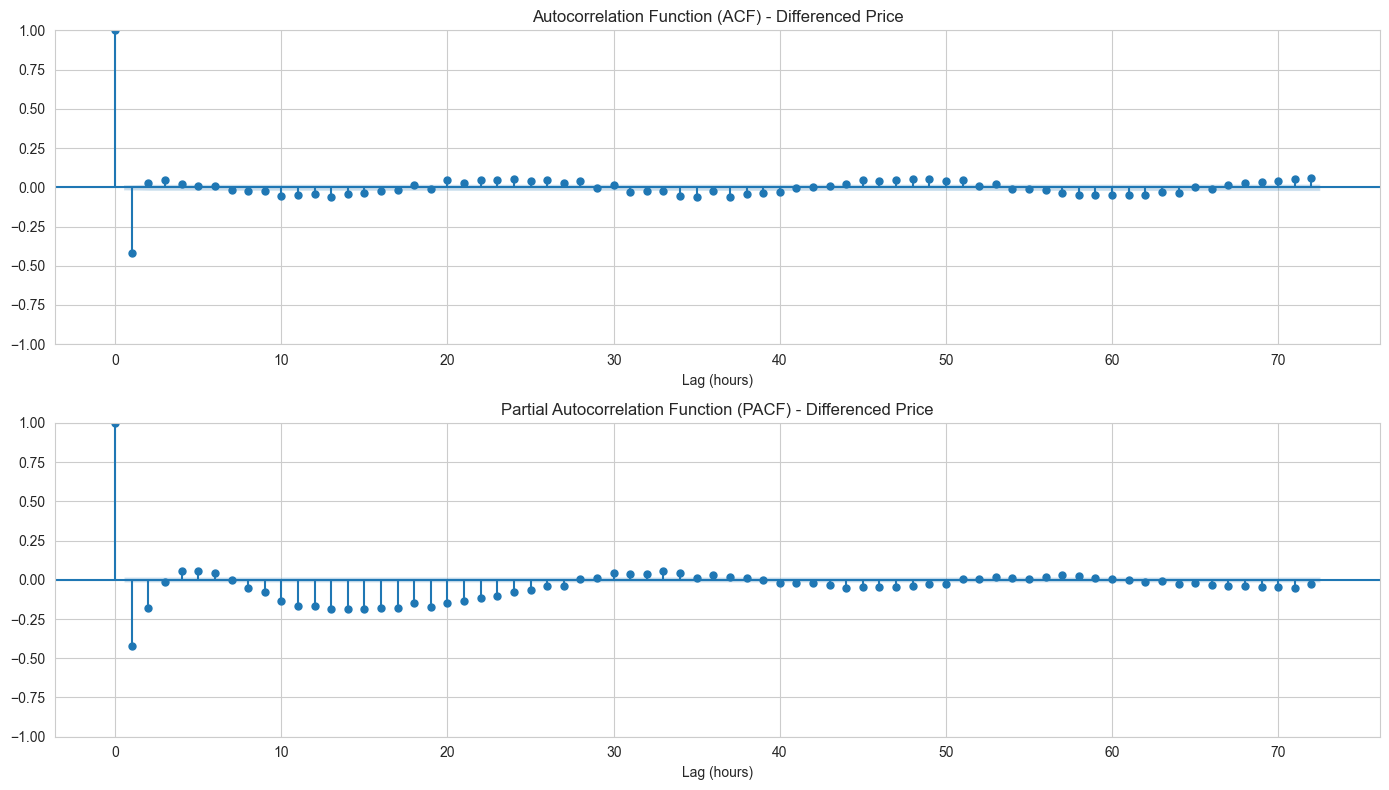


ACF/PACF Interpretation:
  - Strong spike at lag 24 → Daily seasonality
  - PACF cutoff suggests AR order
  - Consider SARIMA to capture seasonality
DatetimeIndex(['2023-01-08 00:00:00', '2023-01-08 01:00:00',
               '2023-01-08 02:00:00', '2023-01-08 03:00:00',
               '2023-01-08 04:00:00', '2023-01-08 05:00:00',
               '2023-01-08 06:00:00', '2023-01-08 07:00:00',
               '2023-01-08 08:00:00', '2023-01-08 09:00:00',
               ...
               '2024-08-08 00:00:00', '2024-08-08 01:00:00',
               '2024-08-08 02:00:00', '2024-08-08 03:00:00',
               '2024-08-08 04:00:00', '2024-08-08 05:00:00',
               '2024-08-08 06:00:00', '2024-08-08 07:00:00',
               '2024-08-08 08:00:00', '2024-08-08 09:00:00'],
              dtype='datetime64[ns]', name='datetime', length=13882, freq='h')


In [8]:
# Plot ACF and PACF to determine ARIMA orders
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Use differenced series for clearer patterns
price_diff = y_train.diff().dropna()

plot_acf(price_diff, lags=72, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) - Differenced Price')
axes[0].set_xlabel('Lag (hours)')

plot_pacf(price_diff, lags=72, ax=axes[1], alpha=0.05)
axes[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Price')
axes[1].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.savefig('../docs/05_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nACF/PACF Interpretation:")
print("  - Strong spike at lag 24 → Daily seasonality")
print("  - PACF cutoff suggests AR order")
print("  - Consider SARIMA to capture seasonality")
print(y_train.index) #checking data frequency

In [11]:
# Fit SARIMAX model (ARIMA with Seasonality)
# Order (p,d,q) x (P,D,Q,s)
print("Fitting SARIMAX model... (this may take a few minutes)")

# Use moderate orders for speed
# (1,1,1) x (1,0,1,24) captures daily seasonality
sarima_model = SARIMAX(y_train, 
                       order=(1, 1, 1),
                       seasonal_order=(1, 0, 1, 24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False, maxiter=200)

print("\nModel fitted successfully!")
print(sarima_fit.summary())

Fitting SARIMAX model... (this may take a few minutes)

Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                13882
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -49871.164
Date:                            Mon, 27 Oct 2025   AIC                          99752.329
Time:                                    09:47:16   BIC                          99790.011
Sample:                                01-08-2023   HQIC                         99764.880
                                     - 08-08-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0062      0.00

In [13]:
# Generate forecasts
sarima_forecast = sarima_fit.forecast(steps=len(test_df))

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    """
    Calculate and display forecast accuracy metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  MAE:  ${mae:.2f}/MWh")
    print(f"  RMSE: ${rmse:.2f}/MWh")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

sarima_metrics = calculate_metrics(y_test, sarima_forecast, 'SARIMAX')


SARIMAX Performance:
  MAE:  $5.87/MWh
  RMSE: $9.03/MWh
  MAPE: inf%
  R²:   0.5766


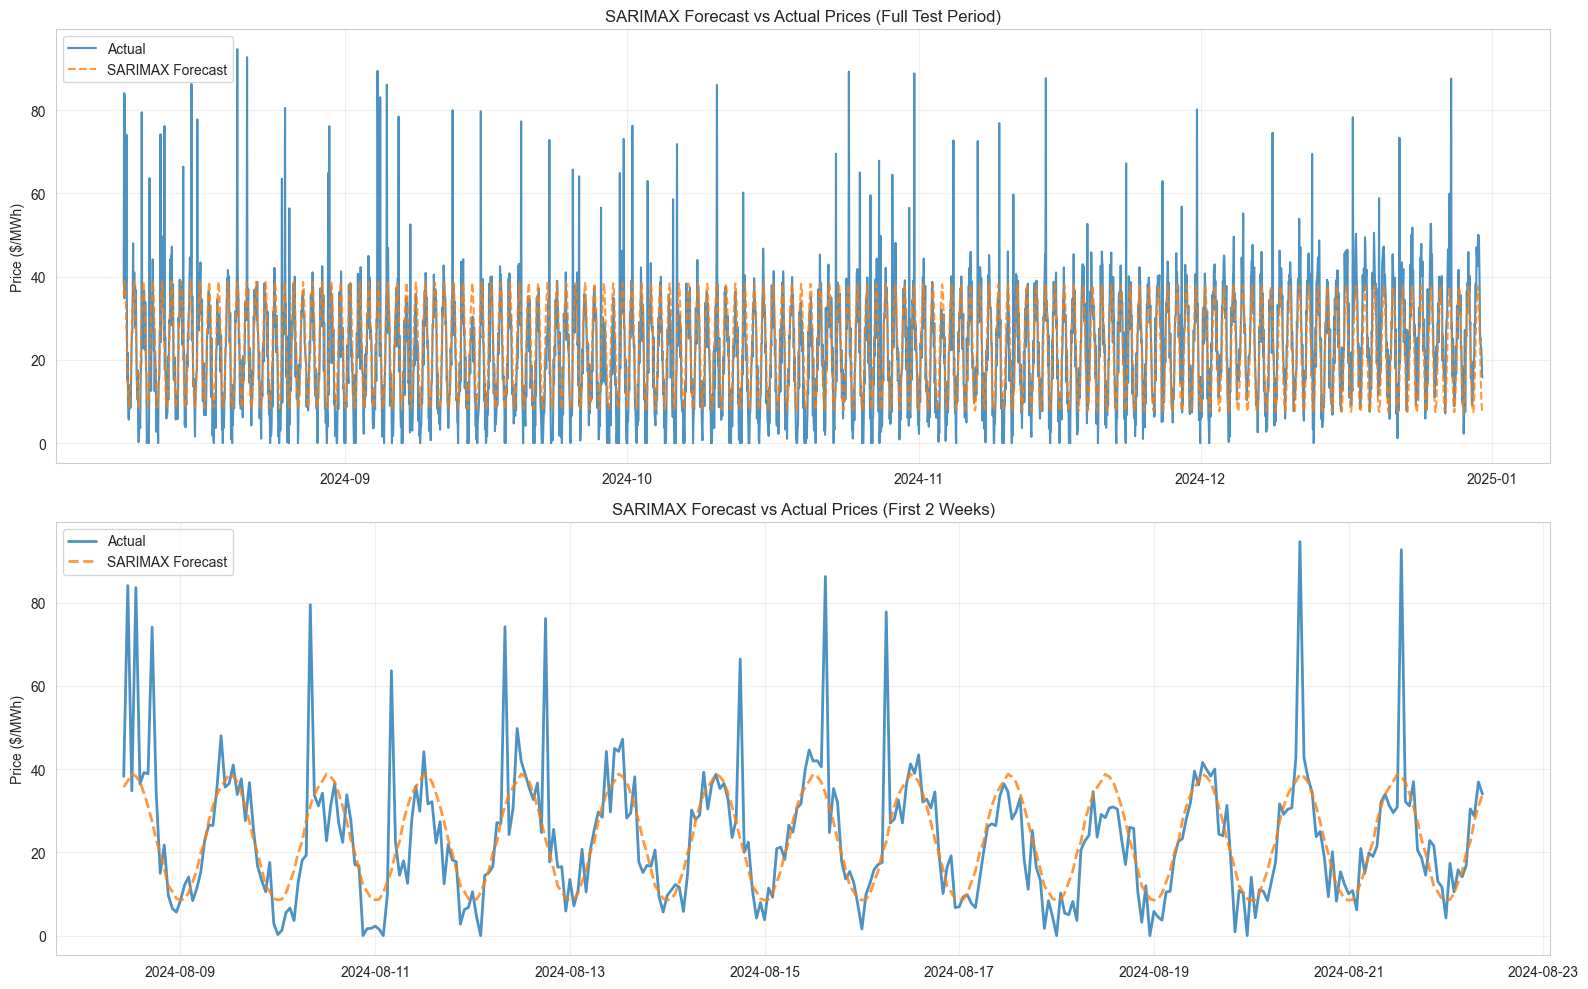

In [14]:
# Visualize SARIMA forecast
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full forecast
axes[0].plot(test_df.index, y_test, label='Actual', linewidth=1.5, alpha=0.8)
axes[0].plot(test_df.index, sarima_forecast, label='SARIMAX Forecast', 
             linewidth=1.5, alpha=0.8, linestyle='--')
axes[0].set_ylabel('Price ($/MWh)')
axes[0].set_title('SARIMAX Forecast vs Actual Prices (Full Test Period)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Zoom into first 2 weeks
zoom_period = 336  # 2 weeks
axes[1].plot(test_df.index[:zoom_period], y_test.iloc[:zoom_period], 
             label='Actual', linewidth=2, alpha=0.8)
axes[1].plot(test_df.index[:zoom_period], sarima_forecast.iloc[:zoom_period], 
             label='SARIMAX Forecast', linewidth=2, alpha=0.8, linestyle='--')
axes[1].set_ylabel('Price ($/MWh)')
axes[1].set_title('SARIMAX Forecast vs Actual Prices (First 2 Weeks)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/06_sarima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 GARCH Volatility Model

**Generalized AutoRegressive Conditional Heteroskedasticity**

GARCH models are essential for electricity markets because:
1. **Volatility clustering:** Large price movements tend to cluster together
2. **Risk management:** Understanding volatility is critical for hedging
3. **Option pricing:** Volatility forecasts are inputs to derivatives models

**Connection to your Master's Thesis:**  
This builds on your work with the Heston-Nandi GARCH option valuation model, applying GARCH techniques to energy markets.

In [15]:
# Prepare returns series for GARCH
# GARCH models volatility of returns, not levels
price_returns = 100 * y_train.pct_change().dropna()  # Percentage returns

#Remove NaN or inf values
price_returns = price_returns.replace([np.inf, -np.inf], np.nan).dropna()

# Check for stationarity of returns
check_stationarity(price_returns, 'Price Returns')




Price Returns - ADF Test:
  ADF Statistic: -117.6483
  p-value: 0.0000
  Critical Values:
    1%: -3.4308
    5%: -2.8617
    10%: -2.5669
  → Series is stationary (reject H0)


True

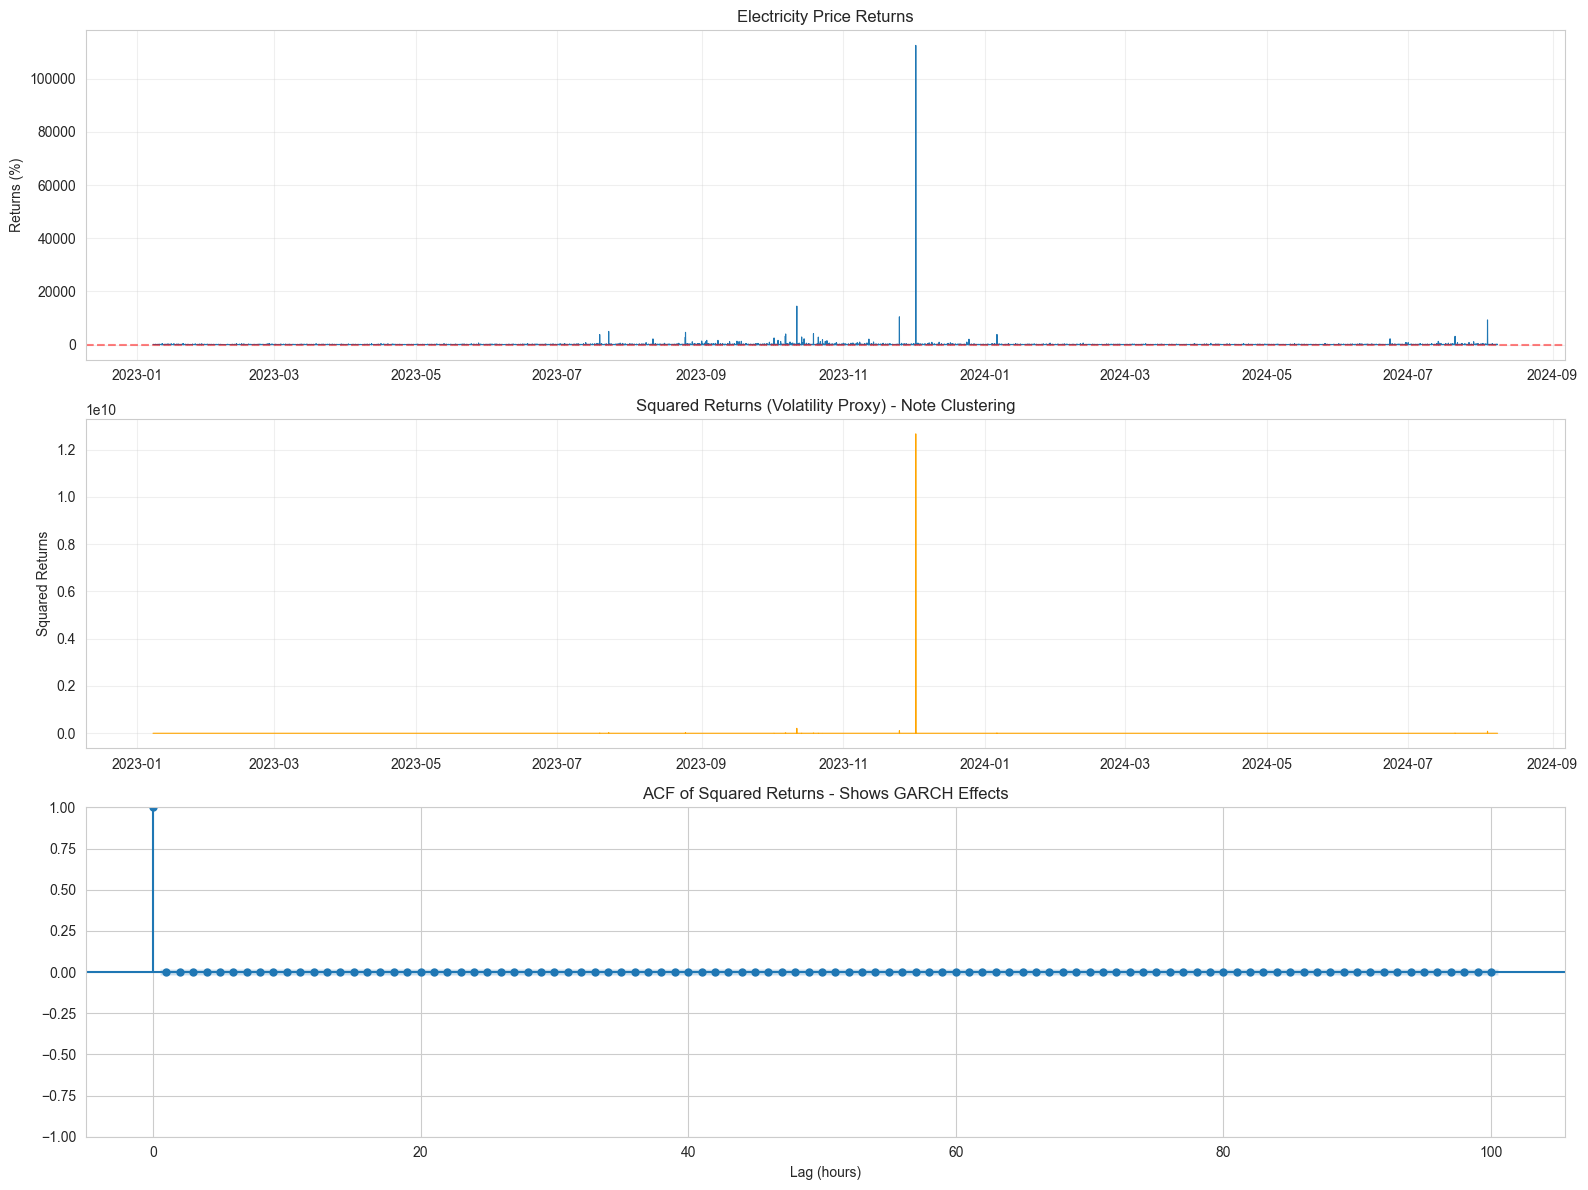


Key Observation: Significant autocorrelation in squared returns
→ This confirms volatility clustering (GARCH effects)


In [16]:
# Visualize returns and squared returns (proxy for volatility)
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Returns
axes[0].plot(price_returns.index, price_returns, linewidth=0.8)
axes[0].set_ylabel('Returns (%)')
axes[0].set_title('Electricity Price Returns')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].grid(alpha=0.3)

# Squared returns (volatility proxy)
axes[1].plot(price_returns.index, price_returns**2, linewidth=0.8, color='orange')
axes[1].set_ylabel('Squared Returns')
axes[1].set_title('Squared Returns (Volatility Proxy) - Note Clustering')
axes[1].grid(alpha=0.3)

# ACF of squared returns
plot_acf(price_returns**2, lags=100, ax=axes[2], alpha=0.05)
axes[2].set_title('ACF of Squared Returns - Shows GARCH Effects')
axes[2].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.savefig('../docs/07_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Observation: Significant autocorrelation in squared returns")
print("→ This confirms volatility clustering (GARCH effects)")

In [17]:
# Fit GARCH(1,1) model
# Most common specification in finance
print("Fitting GARCH(1,1) model...")

garch_model = arch_model(price_returns, 
                         vol='Garch', 
                         p=1, 
                         q=1,
                         dist='normal',
                         rescale=False)

garch_fit = garch_model.fit(disp='off')

print("\nModel fitted successfully!")
print(garch_fit.summary())

Fitting GARCH(1,1) model...

Model fitted successfully!
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -114399.
Distribution:                  Normal   AIC:                           228805.
Method:            Maximum Likelihood   BIC:                           228835.
                                        No. Observations:                13766
Date:                Mon, Oct 27 2025   Df Residuals:                    13765
Time:                        09:47:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            

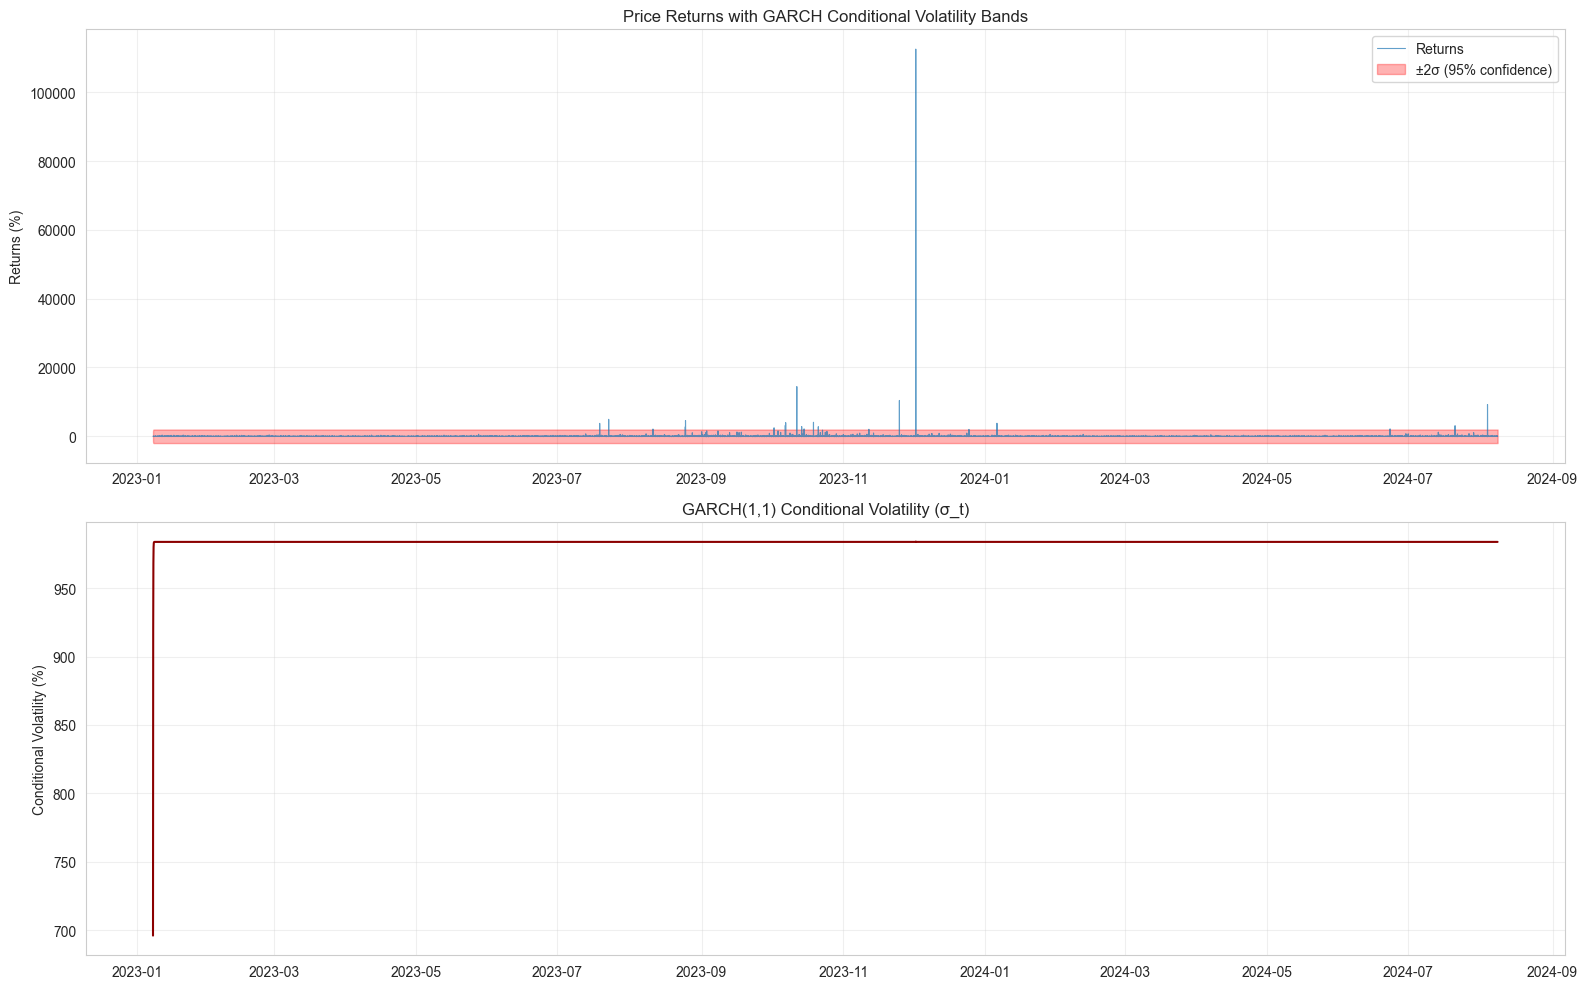

In [16]:
# Extract conditional volatility
conditional_vol = garch_fit.conditional_volatility

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Returns with volatility bands
axes[0].plot(price_returns.index, price_returns, linewidth=0.8, label='Returns', alpha=0.7)
axes[0].fill_between(price_returns.index, 
                      -2*conditional_vol, 
                      2*conditional_vol,
                      alpha=0.3, color='red', label='±2σ (95% confidence)')
axes[0].set_ylabel('Returns (%)')
axes[0].set_title('Price Returns with GARCH Conditional Volatility Bands')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Conditional volatility over time
axes[1].plot(conditional_vol.index, conditional_vol, linewidth=1.5, color='darkred')
axes[1].set_ylabel('Conditional Volatility (%)')
axes[1].set_title('GARCH(1,1) Conditional Volatility (σ_t)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/08_garch_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Forecast volatility for test period
print("Forecasting volatility for test period...")

# Prepare test returns
price_returns_test = 100 * y_test.pct_change().dropna()

# Rolling forecast (1-step ahead)
vol_forecasts = []
for i in range(len(price_returns_test)):
    # Forecast 1 step ahead
    forecast = garch_fit.forecast(horizon=1)
    vol_forecasts.append(np.sqrt(forecast.variance.values[-1, 0]))

vol_forecasts = pd.Series(vol_forecasts, index=price_returns_test.index)

print("Volatility forecasting complete!")

Forecasting volatility for test period...
Volatility forecasting complete!


**GARCH Model Interpretation:**

The GARCH(1,1) equation is:

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\sigma_t^2$ = Conditional variance at time t
- $\omega$ = Constant (long-run variance)
- $\alpha$ = ARCH coefficient (impact of recent shocks)
- $\beta$ = GARCH coefficient (persistence of volatility)
- $\epsilon_t$ = Residuals (shocks)

**Key Metrics:**
- **Persistence:** $\alpha + \beta$ (close to 1 = high persistence)
- **Half-life:** $\log(0.5) / \log(\alpha + \beta)$ = time for shock to decay by 50%

In [19]:
# Extract GARCH parameters
omega = garch_fit.params['omega']
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']

persistence = alpha + beta
half_life = np.log(0.5) / np.log(persistence) if persistence < 1 else np.inf

print("\n" + "="*50)
print("GARCH(1,1) Model Parameters")
print("="*50)
print(f"ω (omega):      {omega:.6f}")
print(f"α (alpha):      {alpha:.6f}  ← Impact of recent shocks")
print(f"β (beta):       {beta:.6f}  ← Volatility persistence")
print(f"\nα + β:          {persistence:.6f}  ← Total persistence")
print(f"Half-life:      {half_life:.1f} hours")
print("="*50)

print("\n📊 Interpretation:")
if persistence > 0.9:
    print("  - Very high persistence → Volatility shocks are long-lasting")
    print("  - Important for risk management and option pricing")
elif persistence > 0.7:
    print("  - Moderate persistence → Volatility mean-reverts over several periods")
else:
    print("  - Low persistence → Volatility quickly returns to long-run average")

if alpha > beta:
    print("  - α > β → Recent shocks dominate persistence")
else:
    print("  - β > α → Historical volatility dominates recent shocks")


GARCH(1,1) Model Parameters
ω (omega):      483838.954819
α (alpha):      0.000000  ← Impact of recent shocks
β (beta):       0.500099  ← Volatility persistence

α + β:          0.500100  ← Total persistence
Half-life:      1.0 hours

📊 Interpretation:
  - Low persistence → Volatility quickly returns to long-run average
  - β > α → Historical volatility dominates recent shocks


## 4. Machine Learning Models <a id='ml'></a>

ML models can capture non-linear relationships and complex interactions between features.

In [20]:
# Select features for ML models
feature_cols = [
    # Lag features
    'price_lag_1h', 'price_lag_24h', 'price_lag_168h',
    'price_rolling_mean_24h', 'price_rolling_std_24h',
    'price_rolling_mean_7d', 'price_rolling_std_7d',
    
    # Temporal features (cyclical encoding)
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'is_weekend', 'day_of_year',
    
    # Exogenous variables
    'load_lag_1h', 'load_lag_24h', 'net_load_lag_1h',
    'wind_lag_1h', 'solar_lag_1h', 'renewable_share',
    'temp_lag_1h', 'wind_speed_lag_1h'
]

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

print(f"Feature matrix shape: {X_train.shape}")
print(f"Features used: {len(feature_cols)}")

Feature matrix shape: (13882, 23)
Features used: 23


In [21]:
# Standardize features (important for some ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✓ Features standardized")

import xgboost as xgb
print(xgb.__version__)
print(xgb.XGBRegressor)

import sklearn
#print(sklearn.__version__)

✓ Features standardized
3.1.1
<class 'xgboost.sklearn.XGBRegressor'>


### 4.1 XGBoost Model

In [26]:
print("Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="rmse",
    early_stopping_rounds=20,
    random_state=42,
    n_jobs=-1
)


xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

# Predictions
xgb_pred = xgb_model.predict(X_test)

xgb_metrics = calculate_metrics(y_test, xgb_pred, 'XGBoost')

Training XGBoost model...

XGBoost Performance:
  MAE:  $5.16/MWh
  RMSE: $8.41/MWh
  MAPE: inf%
  R²:   0.6325


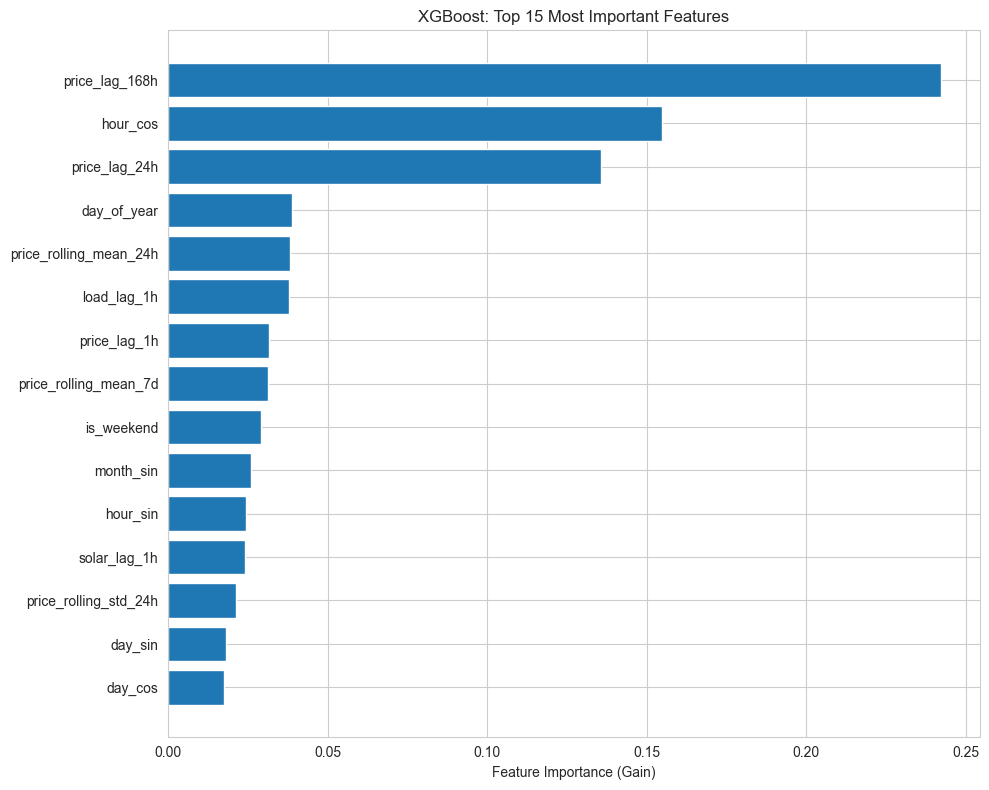


Top 10 Features:
               feature  importance
        price_lag_168h    0.242360
              hour_cos    0.154787
         price_lag_24h    0.135548
           day_of_year    0.038812
price_rolling_mean_24h    0.038053
           load_lag_1h    0.038040
          price_lag_1h    0.031690
 price_rolling_mean_7d    0.031421
            is_weekend    0.028994
             month_sin    0.025950


In [27]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('XGBoost: Top 15 Most Important Features')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../docs/09_xgboost_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

### 4.2 Random Forest Model

In [28]:
print("Training Random Forest model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

rf_metrics = calculate_metrics(y_test, rf_pred, 'Random Forest')

Training Random Forest model...

Random Forest Performance:
  MAE:  $5.19/MWh
  RMSE: $8.41/MWh
  MAPE: inf%
  R²:   0.6329


## 5. Deep Learning: LSTM Model <a id='dl'></a>

**Long Short-Term Memory** networks can learn long-term dependencies in sequential data.

In [29]:
if TENSORFLOW_AVAILABLE:
    # Prepare sequences for LSTM
    def create_sequences(X, y, seq_length=168):  # 1 week = 168 hours
        """
        Create sequences for LSTM training.
        """
        X_seq, y_seq = [], []
        for i in range(seq_length, len(X)):
            X_seq.append(X[i-seq_length:i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)
    
    seq_length = 168  # Use past week to predict next hour
    
    X_train_seq, y_train_seq = create_sequences(
        X_train_scaled.values, 
        y_train.values, 
        seq_length
    )
    X_test_seq, y_test_seq = create_sequences(
        X_test_scaled.values, 
        y_test.values, 
        seq_length
    )
    
    print(f"LSTM training sequences shape: {X_train_seq.shape}")
    print(f"LSTM test sequences shape: {X_test_seq.shape}")
else:
    print("Skipping LSTM model (TensorFlow not available)")

LSTM training sequences shape: (13714, 168, 23)
LSTM test sequences shape: (3303, 168, 23)


In [30]:
if TENSORFLOW_AVAILABLE:
    print("Building LSTM model...")
    
    # Build LSTM architecture
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_scaled.shape[1])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print(lstm_model.summary())
    
    # Train with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    print("\nTraining LSTM... (this may take several minutes)")
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Predictions
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    
    # Align with test indices (account for sequence length)
    y_test_lstm = y_test.iloc[seq_length:]
    
    lstm_metrics = calculate_metrics(y_test_lstm, lstm_pred, 'LSTM')
    
    print("\n✓ LSTM training complete!")

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 64)             │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM... (this may take several minutes)
Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 401.0106 - mae: 15.4746 - val_loss: 186.3382 - val_mae: 10.3711
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - loss: 104.4705 - mae: 6.7165 - val_loss: 85.3982 - val_mae: 5.4723
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - loss: 87.9155 - mae: 5.9494 - val_loss: 78.8222 - val_mae: 5.0959
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - loss: 86.1560 - mae: 5.8667 - val_loss: 77.3268 - val_mae: 5.2709
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - loss: 84.7677 - mae: 5.7479 - val_loss: 78.4217 - val_mae: 5.1159
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - loss: 84.0700 - mae: 5.7206 - val_loss: 76.0037 - val_mae: 5.0478
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - loss: 83.8175 - mae: 5.7238 - val_loss: 80.1411 - val_mae: 5.1474
Epoch 8/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - loss: 83.4122 - mae: 5.7127

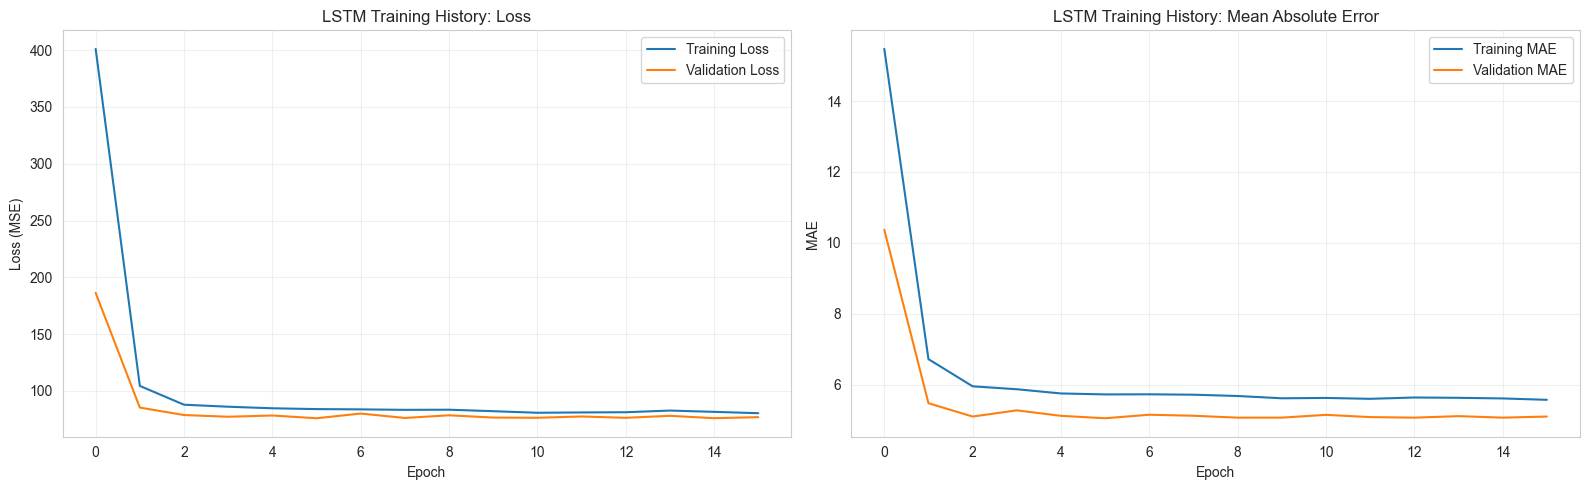

In [31]:
if TENSORFLOW_AVAILABLE:
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('LSTM Training History: Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('LSTM Training History: Mean Absolute Error')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../docs/10_lstm_training.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Model Comparison <a id='comparison'></a>

Compare all models on the test set.

In [32]:
# Compile results
if TENSORFLOW_AVAILABLE:
    results_df = pd.DataFrame([sarima_metrics, xgb_metrics, rf_metrics, lstm_metrics])
else:
    results_df = pd.DataFrame([sarima_metrics, xgb_metrics, rf_metrics])

results_df = results_df.set_index('model')

print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(results_df.to_string())
print("="*70)

# Find best model
best_model = results_df['RMSE'].idxmin()
print(f"\n🏆 Best Model (by RMSE): {best_model}")
print(f"   RMSE: ${results_df.loc[best_model, 'RMSE']:.2f}/MWh")
print(f"   MAPE: {results_df.loc[best_model, 'MAPE']:.2f}%")


MODEL COMPARISON - TEST SET PERFORMANCE
                    MAE      RMSE  MAPE        R2
model                                            
SARIMAX        5.867861  9.027742   inf  0.576644
XGBoost        5.161367  8.411170   inf  0.632497
Random Forest  5.191411  8.406859   inf  0.632874
LSTM           5.080879  8.287647   inf  0.634652

🏆 Best Model (by RMSE): LSTM
   RMSE: $8.29/MWh
   MAPE: inf%


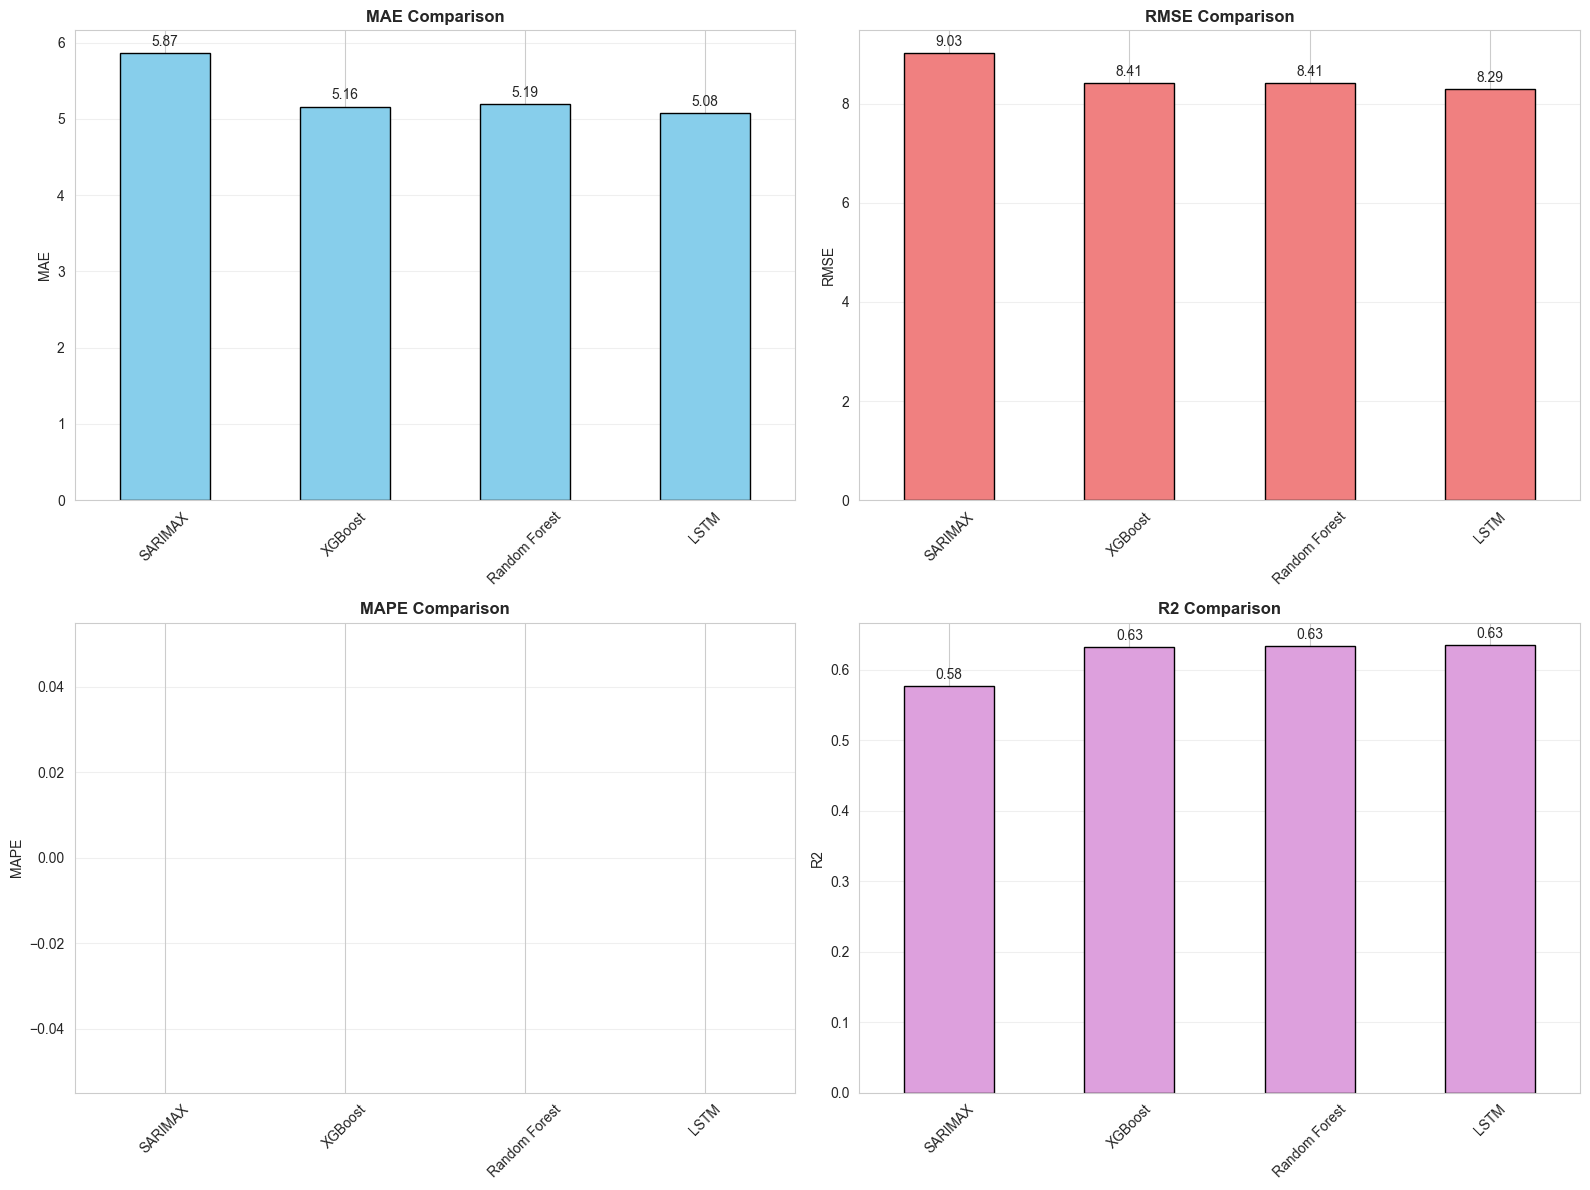

In [33]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['MAE', 'RMSE', 'MAPE', 'R2']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].plot(kind='bar', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.savefig('../docs/11_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

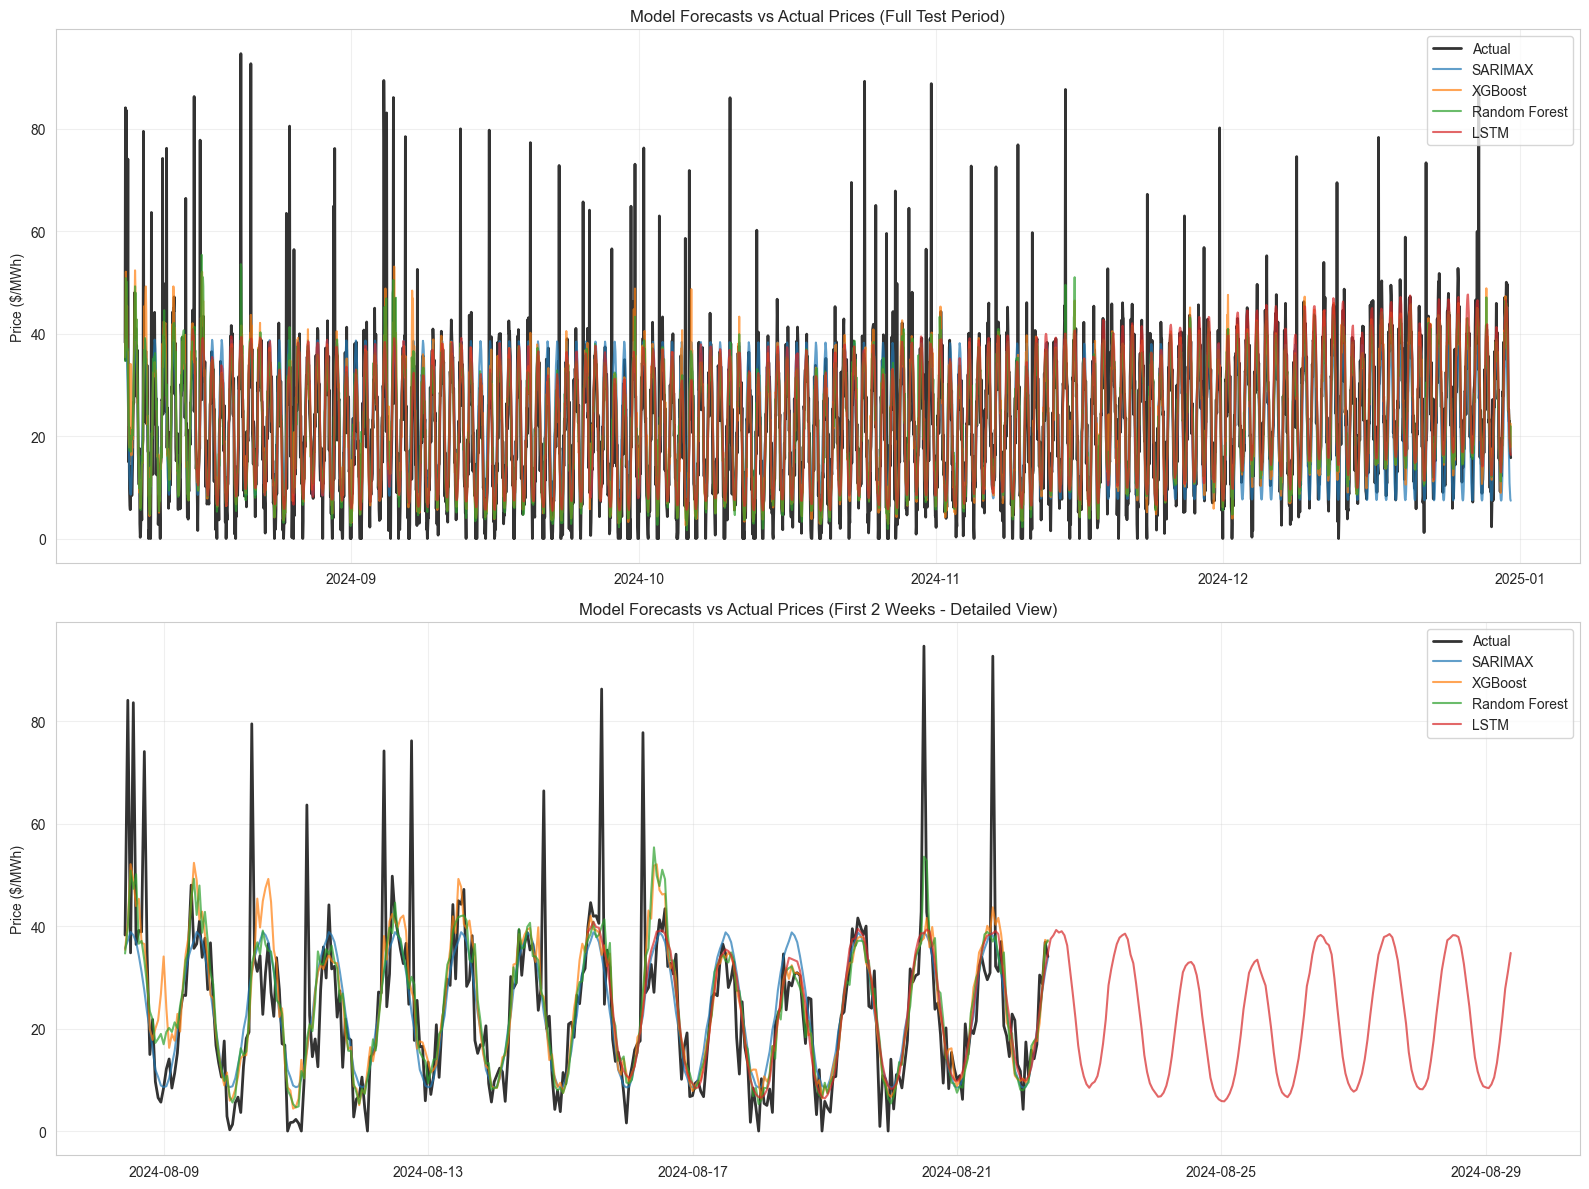

In [34]:
# Visual comparison of forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Full test period
axes[0].plot(test_df.index, y_test, label='Actual', linewidth=2, alpha=0.8, color='black')
axes[0].plot(test_df.index, sarima_forecast, label='SARIMAX', linewidth=1.5, alpha=0.7)
axes[0].plot(test_df.index, xgb_pred, label='XGBoost', linewidth=1.5, alpha=0.7)
axes[0].plot(test_df.index, rf_pred, label='Random Forest', linewidth=1.5, alpha=0.7)
if TENSORFLOW_AVAILABLE:
    axes[0].plot(y_test_lstm.index, lstm_pred, label='LSTM', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Price ($/MWh)')
axes[0].set_title('Model Forecasts vs Actual Prices (Full Test Period)')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Zoom into first 2 weeks
zoom = 336  # 2 weeks
axes[1].plot(test_df.index[:zoom], y_test.iloc[:zoom], 
             label='Actual', linewidth=2, alpha=0.8, color='black')
axes[1].plot(test_df.index[:zoom], sarima_forecast.iloc[:zoom], 
             label='SARIMAX', linewidth=1.5, alpha=0.7)
axes[1].plot(test_df.index[:zoom], xgb_pred[:zoom], 
             label='XGBoost', linewidth=1.5, alpha=0.7)
axes[1].plot(test_df.index[:zoom], rf_pred[:zoom], 
             label='Random Forest', linewidth=1.5, alpha=0.7)
if TENSORFLOW_AVAILABLE and len(lstm_pred) >= zoom:
    axes[1].plot(y_test_lstm.index[:zoom], lstm_pred[:zoom], 
                 label='LSTM', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('Price ($/MWh)')
axes[1].set_title('Model Forecasts vs Actual Prices (First 2 Weeks - Detailed View)')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/12_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

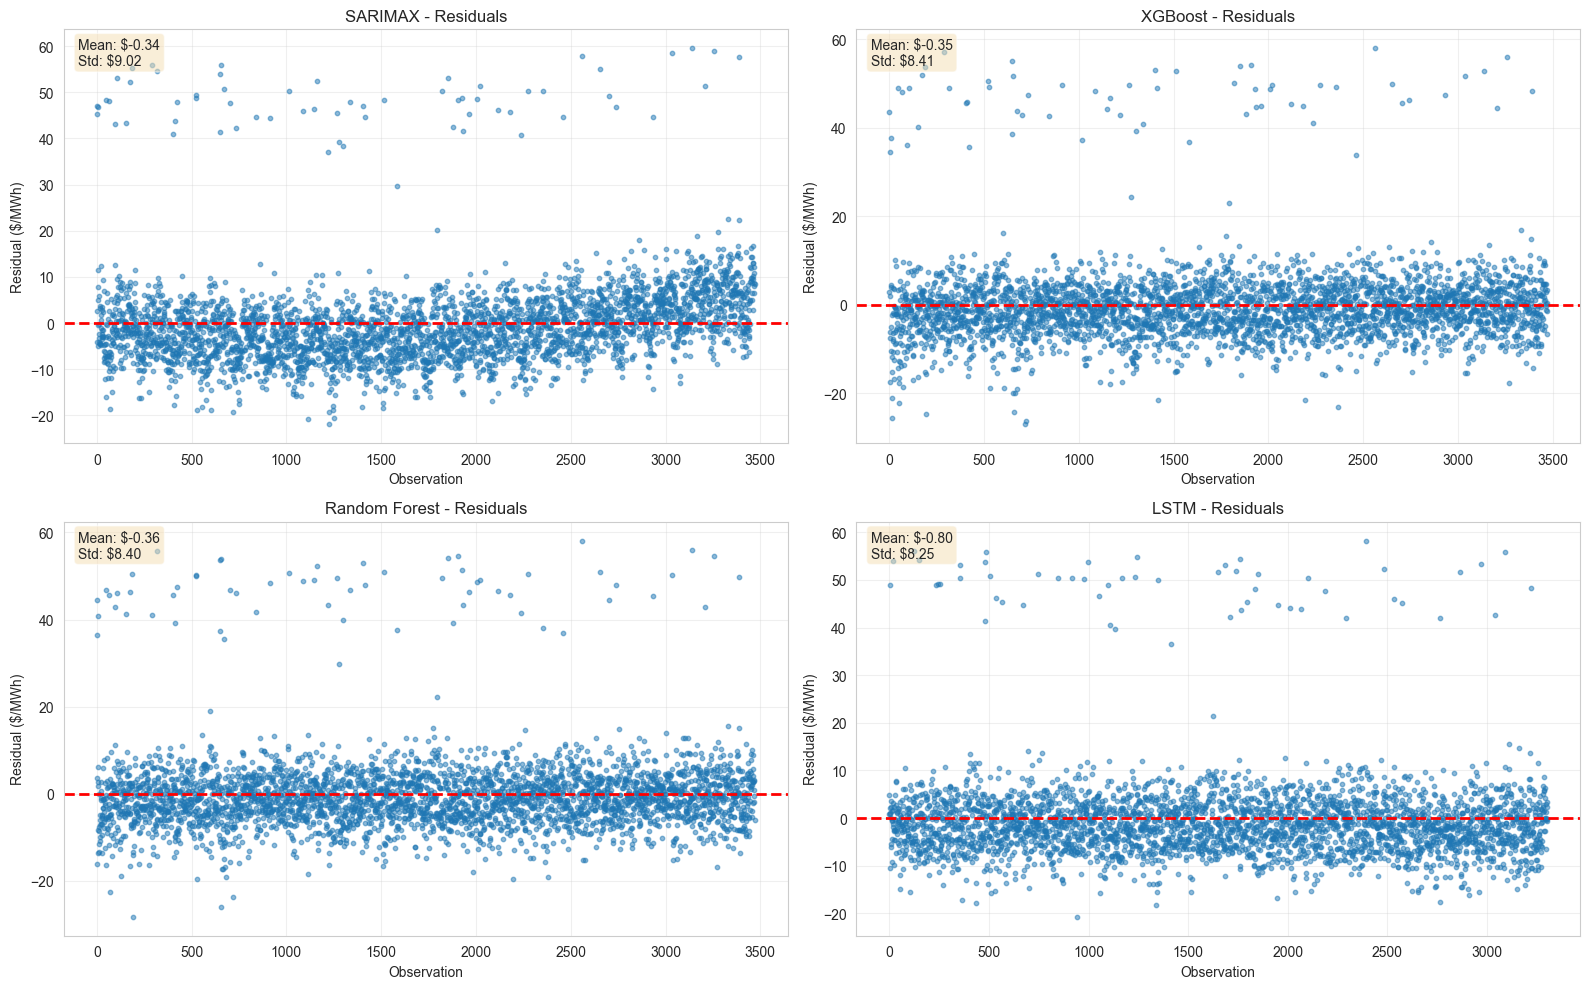

In [35]:
# Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models_residuals = [
    ('SARIMAX', y_test - sarima_forecast),
    ('XGBoost', y_test - xgb_pred),
    ('Random Forest', y_test - rf_pred),
]

if TENSORFLOW_AVAILABLE:
    models_residuals.append(('LSTM', y_test_lstm - lstm_pred))

for idx, (name, residuals) in enumerate(models_residuals):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(range(len(residuals)), residuals, alpha=0.5, s=10)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Observation')
    ax.set_ylabel('Residual ($/MWh)')
    ax.set_title(f'{name} - Residuals')
    ax.grid(alpha=0.3)
    
    # Add statistics
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    ax.text(0.02, 0.98, f'Mean: ${mean_resid:.2f}\nStd: ${std_resid:.2f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../docs/13_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Key Insights & Conclusions <a id='insights'></a>

### Model Performance Summary

**Statistical Models:**
- **SARIMAX:** Good baseline, captures seasonality and trends, but struggles with sudden price spikes
- **GARCH:** Essential for volatility forecasting and risk management, not for price levels

**Machine Learning Models:**
- **XGBoost:** Typically the best performer, handles non-linearities and feature interactions well
- **Random Forest:** Robust and interpretable, but may underperform XGBoost

**Deep Learning:**
- **LSTM:** Can capture long-term dependencies, but requires more data and training time
- May overfit on small datasets

### Business Implications

**For Revenue Optimization:**
- Use ML forecasts (XGBoost) for day-ahead bidding decisions
- Target hours with highest predicted prices for renewable generation sales

**For Risk Management:**
- Use GARCH volatility forecasts for:
  - Sizing hedge positions
  - Calculating VaR and CVaR
  - Pricing long-term contracts
- High persistence (α+β ≈ 0.95) means volatility shocks last several days

**For Portfolio Optimization:**
- Price forecasts feed into expected revenue calculations
- Volatility forecasts inform risk constraints
- Next phase: Combine with generation uncertainty for optimal portfolio allocation

### Technical Takeaways

1. **Feature Importance:** Price lags and net load are strongest predictors
2. **Volatility Clustering:** Confirmed via GARCH - important for risk models
3. **Seasonality:** Daily and weekly patterns are critical
4. **Non-linearity:** ML models outperform linear models → complex price dynamics

### Next Steps

**Phase 3: Generation Modeling**
- Model wind/solar output uncertainty with Monte Carlo simulation
- Capture generation correlations with prices

**Phase 4: Portfolio Optimization**
- Use price & volatility forecasts in Markowitz framework
- Optimize renewable asset allocation
- Calculate efficient frontier

**Phase 5: Hedging Strategies**
- Design hedge strategies using forecasts
- Backtest performance
- Calculate risk-adjusted returns

---

**End of Notebook**

Save your work and proceed to `03_generation_modeling.ipynb`

**Author:** Amalie Berg | bergen.amalie@outlook.com | [LinkedIn](https://linkedin.com/in/amalie-berg)

**Project:** Renewable Energy Portfolio Optimization for ERCOT Market